<a href="https://colab.research.google.com/github/virgiawan/yog2a-melanoma/blob/master/Melanoma_(Wildan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Detection App
---

## Data Preprocessing

### Data Download

Sebelum mengimport data dari Kaggle, kita perlu mendownload API token terlebih dahulu. API token ini bisa kita download dengan cara: **Login di Kaggle > My Account > Home > Create New API Token**. API token ini akan terdownload dalam bentuk file kaggle.json dan harus kita upload ke google colab

In [0]:
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abuwildanm","key":"cf45bfabf4aeb5a95547f59e04a023be"}'}

Supaya dapat mengimport dataset dari Kaggle, jalankan perintah berikut

In [0]:
# Install kaggle library 
!pip install -q kaggle
# Make ".kaggle" directory in root directory
!mkdir -p ~/.kaggle
# Copy the API token to the kaggle directory
!cp kaggle.json ~/.kaggle/
# Check the directory
!ls ~/.kaggle
# Adjust access permissions
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


Setelah itu kita dapat mendownload dataset dari Kaggle dengan perintah berikut

In [0]:
# Download the data
!kaggle datasets download -d drscarlat/melanoma
!unzip -q melanoma.zip -d .
!ls

100% 5.25G/5.26G [01:51<00:00, 31.9MB/s]
100% 5.26G/5.26G [01:51<00:00, 50.7MB/s]
dermmel  DermMel  kaggle.json  melanoma.zip  sample_data


Dataset tersebut berisi beberapa direktori yang menyimpan data untuk training, validation, dan testing. Oleh karena itu, untuk setiap direktori yang ada, kita perlu menyimpan path-nya.

Dataset tersebut juga berisi 2 subdirektori yang mendefinisikan label yaitu `Melanoma` dan `NotMelanoma`. Training set kita gunakan untuk melatih neural network mana gambar yang memiliki penyakit melanoma atau tidak. Validation set adalah dataset yang belum terlihat sebelumnya oleh neural network sehingga kita bisa menguji performa neural network. Test set adalah dataset yang digunakan untuk menguji kemampuan neural network setelah dilakukan training dan validation.

In [0]:
import os

base_dir = '/content/DermMel'

train_dir = os.path.join(base_dir, 'train_sep')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Label
melanoma = 'Melanoma'
not_melanoma = 'NotMelanoma'

# Train dataset directory
train_melanoma_dir = os.path.join(train_dir, melanoma)
train_not_melanoma_dir = os.path.join(train_dir, not_melanoma)

# Validation dataset directory
validation_melanoma_dir = os.path.join(validation_dir, melanoma)
validation_not_melanoma_dir = os.path.join(validation_dir, not_melanoma)

# Test dataset directory
test_melanoma_dir = os.path.join(test_dir, melanoma)
test_not_melanoma_dir = os.path.join(test_dir, not_melanoma)

Untuk mengecek apakah path yang sudah kita buat berhasil dibaca, maka kita harus menge-print nya

In [0]:
train_melanoma_fnames = os.listdir(train_melanoma_dir)
train_not_melanoma_fnames = os.listdir(train_not_melanoma_dir)

print(train_melanoma_fnames[:10])
print(train_not_melanoma_fnames[:10])

['AUG_0_2527.jpeg', 'AUGmented_0_3669.jpeg', 'AUG_0_4949.jpeg', 'AUGmented_0_3076.jpeg', 'ISIC_0033872.jpg', 'AUG_0_3966.jpeg', 'AUGmented_0_2432.jpeg', 'AUG_0_678.jpeg', 'AUG_0_3365.jpeg', 'AUGmented_0_640.jpeg']
['ISIC_0033475.jpg', 'ISIC_0033602.jpg', 'ISIC_0032614.jpg', 'ISIC_0030583.jpg', 'ISIC_0032454.jpg', 'ISIC_0028070.jpg', 'ISIC_0032067.jpg', 'ISIC_0032446.jpg', 'ISIC_0026658.jpg', 'ISIC_0027047.jpg']


Disini kita akan membuat direktori baru untuk menampung test dataset yang baru. Kita akan mengambil 100 image dari test set dimana 50 image adalah melanoma dan 50 image adalah not melanoma. Test set yang baru ini akan kita gunakan untuk mengevaluasi model dengan menggunakan confusion matrix dan ROC curve. Pengurangan jumlah test set juga untuk mempercepat proses evaluasi model

In [0]:
# Create test directory which contains only 100 images
test_100_dir = os.path.join(base_dir, 'test_100')
try: 
    os.makedirs(test_100_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(test_100_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(test_100_dir))

# Create test melanoma directory which contains only 50 images 
test_100_melanoma_dir = os.path.join(test_100_dir, melanoma)
try: 
    os.makedirs(test_100_melanoma_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(test_100_melanoma_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(test_100_melanoma_dir))

# Create test not melanoma directory which contains only 50 images
test_100_not_melanoma_dir = os.path.join(test_100_dir, not_melanoma)
try: 
    os.makedirs(test_100_not_melanoma_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(test_100_not_melanoma_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(test_100_not_melanoma_dir))

Directory /content/DermMel/test_100 created successfully
Directory /content/DermMel/test_100/Melanoma created successfully
Directory /content/DermMel/test_100/NotMelanoma created successfully


In [0]:
from shutil import copy

# Obtain 50 image fnames from test melanoma and not melanoma dir
test_melanoma_fnames = os.listdir(test_melanoma_dir)[:50]
test_not_melanoma_fnames = os.listdir(test_not_melanoma_dir)[:50]

# Obtain 50 image path from test melanoma and not melanoma dir
test_melanoma_path = [os.path.join(test_melanoma_dir, fname) for fname in test_melanoma_fnames]
test_not_melanoma_path = [os.path.join(test_not_melanoma_dir, fname) for fname in test_not_melanoma_fnames]

# Copy 50 images of melanoma and not melanoma from test directory to test_100 directory
for melanoma_path, not_melanoma_path in zip(test_melanoma_path, test_not_melanoma_path):
    copy(melanoma_path, test_100_melanoma_dir)
    copy(not_melanoma_path, test_100_not_melanoma_dir)

Di bawah ini kita bisa melihat jumlah image pada masing-masing direktori. Terlihat bahwa test set awal berjumlah `3561 images` dan test set yang baru berjumlah `100 images`

In [0]:
total_train = len(os.listdir(train_melanoma_dir)) + len(os.listdir(train_not_melanoma_dir))
total_validation = len(os.listdir(validation_melanoma_dir)) + len(os.listdir(validation_not_melanoma_dir))
total_test = len(os.listdir(test_melanoma_dir)) + len(os.listdir(test_not_melanoma_dir))
total_test_100 = len(os.listdir(test_100_not_melanoma_dir)) + len(os.listdir(test_100_not_melanoma_dir))

print('Total training melanoma images:', len(os.listdir(train_melanoma_dir)))
print('Total training not melanoma images:', len(os.listdir(train_not_melanoma_dir)))
print('Total training images:', total_train)
print()
print('Total validation melanoma images:', len(os.listdir(validation_melanoma_dir)))
print('Total validation not melanoma images:', len(os.listdir(validation_not_melanoma_dir)))
print('Total validation images:', total_validation)
print()
print('Total testing melanoma images:', len(os.listdir(test_melanoma_dir)))
print('Total testing not melanoma images:', len(os.listdir(test_not_melanoma_dir)))
print('Total testing images:', total_test)
print()
print('Total testing melanoma images (short):', len(os.listdir(test_100_melanoma_dir)))
print('Total testing not melanoma images (short):', len(os.listdir(test_100_not_melanoma_dir)))
print('Total testing images (short):', total_test_100)

Total training melanoma images: 5341
Total training not melanoma images: 5341
Total training images: 10682

Total validation melanoma images: 1781
Total validation not melanoma images: 1781
Total validation images: 3562

Total testing melanoma images: 1781
Total testing not melanoma images: 1780
Total testing images: 3561

Total testing melanoma images (short): 50
Total testing not melanoma images (short): 50
Total testing images (short): 100


### Format the data

Sebelum data diproses ke dalam model, maka kita perlu melakukan preprocessing data terlebih dahulu. Preprocessing data kita lakukan menggunakan module dari Tensorflow yaitu `ImageDataGenerator` dan diterapkan pada train, validation, dan test set.

Pada training set, kita lakukan image augmentation. Image augmentation bertujuan untuk memperbanyak data sehingga tidak terjadi overfitting (model terlalu mengenali training set ==> memorization, sehingga ketika diberikan data yang belum pernah dilihat oleh model, model gagal mengenali data tersebut).  

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20
target_size = (224, 224)

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
# train_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagen  = ImageDataGenerator(rescale = 1.0/255)

# Specify the image classes
classes = ['NotMelanoma', 'Melanoma']

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=classes,
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using validation_datagen generator
# --------------------
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=batch_size,
                                                              class_mode='binary',
                                                              classes=classes,
                                                              target_size=target_size)
# --------------------
# Flow testing images in batches of 100 using test_datagen generator
# --------------------
test_generator = test_datagen.flow_from_directory(test_100_dir,
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  classes=classes,
                                                  target_size=target_size)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [0]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'NotMelanoma': 0, 'Melanoma': 1}
{'NotMelanoma': 0, 'Melanoma': 1}
{'NotMelanoma': 0, 'Melanoma': 1}


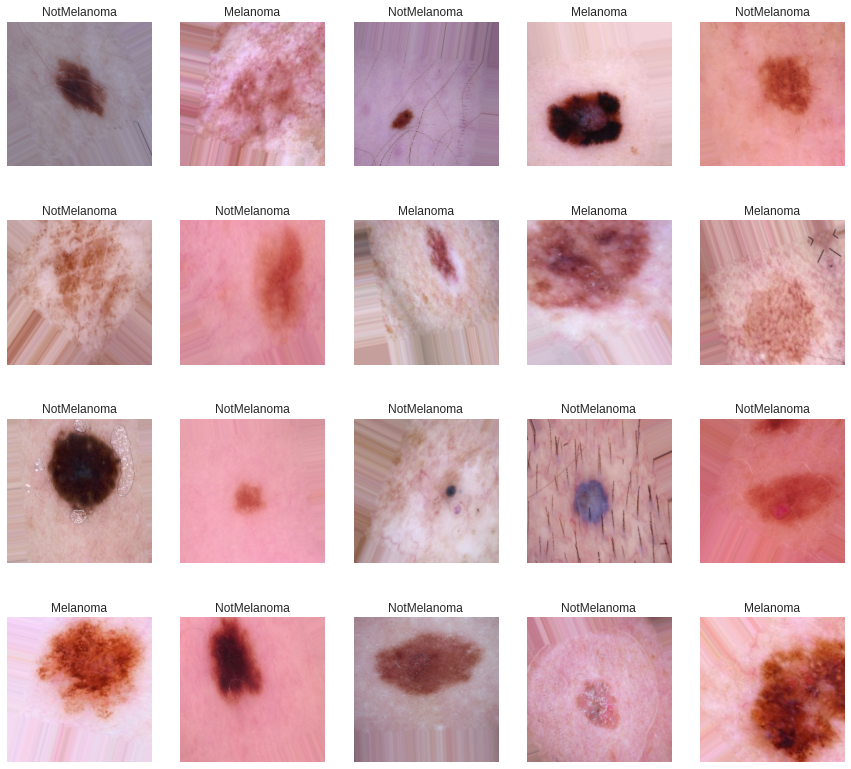

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf

# Obtain one batch of testing images
images, labels = next(train_generator)
labels = labels.astype('int')

# Plot the images in the batch, along with predicted and true labels
nrows = 4
ncols = batch_size / nrows
fig = plt.figure(figsize=(15, 14))
for idx in range(20):
    ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Create the base model from the pre-trained convnets

In [0]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, Xception, DenseNet121

# base_model = InceptionV3(input_shape=(224,224,3), include_top=False)
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
feature_batch = base_model(images)
print(feature_batch.shape)

(20, 7, 7, 1280)


## Feature Extraction

### Freeze the convolutional base

In [0]:
base_model.trainable = False

print(base_model.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 Conv1_pad False
2 Conv1 False
3 bn_Conv1 False
4 Conv1_relu False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_BN False
7 expanded_conv_depthwise_relu False
8 expanded_conv_project False
9 expanded_conv_project_BN False
10 block_1_expand False
11 block_1_expand_BN False
12 block_1_expand_relu False
13 block_1_pad False
14 block_1_depthwise False
15 block_1_depthwise_BN False
16 block_1_depthwise_relu False
17 block_1_project False
18 block_1_project_BN False
19 block_2_expand False
20 block_2_expand_BN False
21 block_2_expand_relu False
22 block_2_depthwise False
23 block_2_depthwise_BN False
24 block_2_depthwise_relu False
25 block_2_project False
26 block_2_project_BN False
27 block_2_add False
28 block_3_expand False
29 block_3_expand_BN False
30 block_3_expand_relu False
31 block_3_pad False
32 block_3_depthwise False
33 block_3_depthwise_BN False
34 block_3_depthwise_relu False
35 block_3_project False
36 block_3_project_BN False
37 block_4_expand Fa

### Add a classification head

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, ReLU, Add, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD
from tensorflow.keras.metrics import Precision, Recall

In [0]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(20, 1280)


In [0]:
prediction_layer = Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(20, 1)


In [0]:
# Baseline MobileNetV2
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Baseline InceptionV3
# model = Sequential()
# model.add(base_model)
# model.add(Flatten())
# # model.add(Dropout(0.2))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# Improvement InceptionV3
# last_layer = base_model.get_layer('mixed9')
# x = Flatten()(last_layer.output)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(1, activation='sigmoid')(x)
# model = Model(base_model.input, x)

### Compile the model

In [0]:
from tensorflow.keras.losses import BinaryCrossentropy

# metrics = ['accuracy', Precision(), Recall()]
base_learning_rate = 1e-03
model.compile(optimizer=Adam(learning_rate=base_learning_rate), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 2,914,369
Trainable params: 656,385
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [0]:
len(model.trainable_variables)

4

### Train the model

In [0]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

# callbacks = myCallback()

# Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-04)
# Callback that records events into a History object
hist = History()

# Create saved_model directory to save the model
saved_model_dir = './saved_model'
saved_model_filepath = os.path.join(saved_model_dir, 'model-{epoch:02d}-{val_accuracy:.2f}')
try: 
    os.makedirs(saved_model_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(saved_model_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(saved_model_dir))

# Callback to save the model at some frequency
model_checkpoint = ModelCheckpoint(saved_model_filepath, 
                                   monitor='val_loss', 
                                   save_best_only=True)

Directory ./saved_model created successfully


In [0]:
initial_epochs = 10
validation_steps = 20

model.evaluate(validation_generator, steps=validation_steps)

20/20 [==============================] - 4s 194ms/step - loss: 0.8904 - accuracy: 0.4425


[0.890368640422821, 0.4424999952316284]

In [0]:
from tensorflow.keras.models import save_model, load_model

# -----------------------------------------------------------------------------
#              If you have saved model, comment this block of code
# -----------------------------------------------------------------------------
history = None
# Check the saved_model directory
if os.path.exists(saved_model_dir):
    # If the saved_model directory is empty, then train the model
    if len(os.listdir(saved_model_dir)) == 0:
        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=total_train // batch_size,
                            epochs=initial_epochs,
                            validation_steps=total_validation // batch_size,
                            # callbacks=[early_stopping, reduce_lr, model_checkpoint, hist],
                            callbacks=[reduce_lr, model_checkpoint, hist],
                            verbose=2)
        
        model.save(os.path.join(saved_model_dir, 'base_model.h5'))
    else:
        best_model_dir = os.listdir(saved_model_dir)[-1]
        best_model = os.path.join(saved_model_dir, best_model_dir)
        model = load_model(best_model)
else:
    print('The saved_model directory cannot be found')
# -----------------------------------------------------------------------------

# Load saved model from path
# saved_model_path = os.path.join(saved_model_dir, 'base_model.h5')
# model = load_model(saved_model_path)

Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_model/model-01-0.93/assets
534/534 - 250s - loss: 0.2379 - accuracy: 0.9086 - val_loss: 0.1776 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 2/10
534/534 - 195s - loss: 0.1956 - accuracy: 0.9234 - val_loss: 0.1870 - val_accuracy: 0.9334 - lr: 0.0010
Epoch 3/10
534/534 - 194s - loss: 0.1793 - accuracy: 0.9311 - val_loss: 0.2274 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 4/10
INFO:tensorflow:Assets written to: ./saved_model/model-04-0.94/assets
534/534 - 221s - loss: 0.1736 - accuracy: 0.9324 - val_loss: 0.1657 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 5/10
534/534 - 195s - loss: 0.1713 - accuracy: 0.9316 - val_loss: 0.1705 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 6/10
534/534 - 193s - loss: 0.1654 - accuracy: 0.9353 - val_loss: 0.1771 - val_accuracy: 0.9284 - lr: 0.0010
Epoch 7/10
534/534 - 195s - loss: 0.1610 - accuracy: 0.9374 - val_loss: 0.1814 - val_accu

In [0]:
model.evaluate(validation_generator, steps=validation_steps)

20/20 [==============================] - 2s 119ms/step - loss: 0.1822 - accuracy: 0.9250


[0.18222875893115997, 0.925000011920929]

In [0]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 112ms/step - loss: 0.2621 - accuracy: 0.9000


[0.2621406614780426, 0.8999999761581421]

Notes:

1. VGG16
   - Epoch = 15
   - Start = 87% val_accuracy
   - End = 90% val_accuracy

2. VGG19
   - Epoch = 15
   - Start = 85% val_accuracy
   - End = 91% val_accuracy
   - Train accurracy decrease ==> weakness

3. MobileNet
   - Epoch = 9
   - Start = 92% val_accuracy
   - End = 94% val_accuracy

4. MobileNetV2
   - Epoch = 10
   - Start = 93% val_accuracy
   - End = 93% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

5. InceptionV3
   - Epoch = 9
   - Start = 92% val_accuracy
   - End = 92% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

6. InceptionResNetV2
   - Epoch = 11
   - Start = 87% val_accuracy
   - End = 90% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train accuracy < valid accuracy ==> weakness
   - Train and valid loss decrease ==> advantage

7. Xception
   - Epoch = 8
   - Start = 92% val_accuracy
   - End = 93% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

8. DenseNet121
   - Epoch = 11
   - Start = 94% val_accuracy
   - End = 94% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train loss decrease and valid loss increase ==> weakness

9. ResNet50
   - Epoch = 6
   - Start = 50% val_accuracy
   - End = 49% val_accuracy

### Learning curves

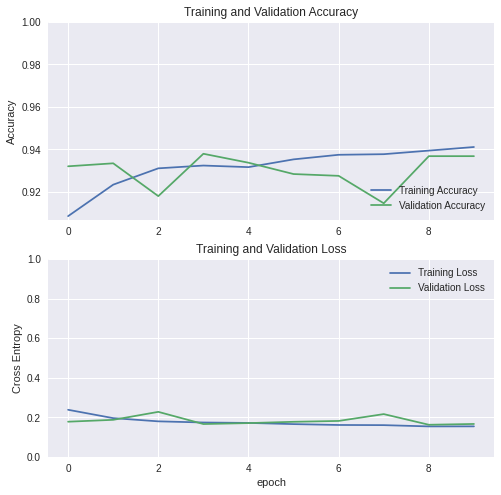

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
def plot_metrics(history):
    # metrics =  ['loss', 'accuracy', 'precision_1', 'recall_1']
    metrics =  ['loss', 'accuracy']
    fig = plt.figure(figsize=(15,10))
    for i, metric in enumerate(metrics):
        name = metric.replace('_',' ').capitalize()
        nrows = 2
        ncols = len(metrics) // nrows if (len(metrics) % 2 == 0) else len(metrics) // nrows + 1

        plt.subplot(nrows, ncols, i+1)
        plt.plot(history.epoch, history.history[metric], color='r', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='b', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Training and validation {}'.format(metric))
        plt.legend()
        plt.tight_layout()

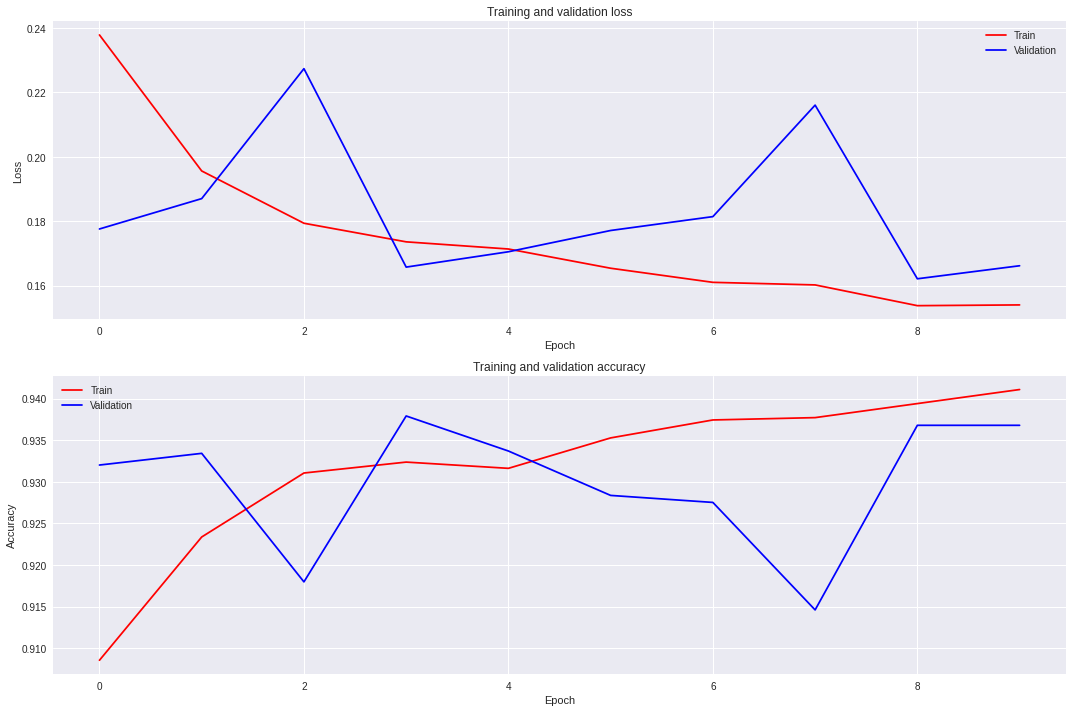

In [0]:
plot_metrics(history)

## Fine Tuning

### Un-freeze the top layers of the model

In [0]:
base_model.trainable = True

In [0]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 Conv1_pad True
2 Conv1 True
3 bn_Conv1 True
4 Conv1_relu True
5 expanded_conv_depthwise True
6 expanded_conv_depthwise_BN True
7 expanded_conv_depthwise_relu True
8 expanded_conv_project True
9 expanded_conv_project_BN True
10 block_1_expand True
11 block_1_expand_BN True
12 block_1_expand_relu True
13 block_1_pad True
14 block_1_depthwise True
15 block_1_depthwise_BN True
16 block_1_depthwise_relu True
17 block_1_project True
18 block_1_project_BN True
19 block_2_expand True
20 block_2_expand_BN True
21 block_2_expand_relu True
22 block_2_depthwise True
23 block_2_depthwise_BN True
24 block_2_depthwise_relu True
25 block_2_project True
26 block_2_project_BN True
27 block_2_add True
28 block_3_expand True
29 block_3_expand_BN True
30 block_3_expand_relu True
31 block_3_pad True
32 block_3_depthwise True
33 block_3_depthwise_BN True
34 block_3_depthwise_relu True
35 block_3_project True
36 block_3_project_BN True
37 block_4_expand True
38 block_4_expand_BN True
39 block

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 117

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [0]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 Conv1_pad False
2 Conv1 False
3 bn_Conv1 False
4 Conv1_relu False
5 expanded_conv_depthwise False
6 expanded_conv_depthwise_BN False
7 expanded_conv_depthwise_relu False
8 expanded_conv_project False
9 expanded_conv_project_BN False
10 block_1_expand False
11 block_1_expand_BN False
12 block_1_expand_relu False
13 block_1_pad False
14 block_1_depthwise False
15 block_1_depthwise_BN False
16 block_1_depthwise_relu False
17 block_1_project False
18 block_1_project_BN False
19 block_2_expand False
20 block_2_expand_BN False
21 block_2_expand_relu False
22 block_2_depthwise False
23 block_2_depthwise_BN False
24 block_2_depthwise_relu False
25 block_2_project False
26 block_2_project_BN False
27 block_2_add False
28 block_3_expand False
29 block_3_expand_BN False
30 block_3_expand_relu False
31 block_3_pad False
32 block_3_depthwise False
33 block_3_depthwise_BN False
34 block_3_depthwise_relu False
35 block_3_project False
36 block_3_project_BN False
37 block_4_expand Fa

### Compile the model

In [0]:
fine_learning_rate = base_learning_rate / 10
model.compile(optimizer=Adam(learning_rate=fine_learning_rate), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 2,914,369
Trainable params: 2,337,729
Non-trainable params: 576,640
_________________________________________________________________
None


In [0]:
len(model.trainable_variables)

43

### Continue training the model

In [0]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=total_train // batch_size,
                    epochs=total_epochs,
                    validation_steps=total_validation // batch_size,
                    # callbacks=[early_stopping, reduce_lr, model_checkpoint, hist],
                    callbacks=[reduce_lr, model_checkpoint, hist],
                    verbose=2)

Epoch 1/20
534/534 - 194s - loss: 0.2146 - accuracy: 0.9177 - val_loss: 0.2290 - val_accuracy: 0.9098 - lr: 1.0000e-04
Epoch 2/20
534/534 - 192s - loss: 0.1769 - accuracy: 0.9329 - val_loss: 2.5642 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 3/20
534/534 - 192s - loss: 0.1598 - accuracy: 0.9384 - val_loss: 0.3047 - val_accuracy: 0.9135 - lr: 1.0000e-04
Epoch 4/20
534/534 - 191s - loss: 0.1512 - accuracy: 0.9418 - val_loss: 0.9507 - val_accuracy: 0.6281 - lr: 1.0000e-04
Epoch 5/20
534/534 - 191s - loss: 0.1429 - accuracy: 0.9434 - val_loss: 0.4708 - val_accuracy: 0.8129 - lr: 1.0000e-04
Epoch 6/20
534/534 - 196s - loss: 0.1354 - accuracy: 0.9470 - val_loss: 0.1672 - val_accuracy: 0.9447 - lr: 1.0000e-04
Epoch 7/20
534/534 - 194s - loss: 0.1242 - accuracy: 0.9485 - val_loss: 0.1727 - val_accuracy: 0.9317 - lr: 1.0000e-04
Epoch 8/20
534/534 - 193s - loss: 0.1203 - accuracy: 0.9526 - val_loss: 0.2970 - val_accuracy: 0.8758 - lr: 1.0000e-04
Epoch 9/20
INFO:tensorflow:Assets written to: ./

In [0]:
model.evaluate(validation_generator, steps=validation_steps)

20/20 [==============================] - 2s 122ms/step - loss: 0.1664 - accuracy: 0.9300


[0.16644227504730225, 0.9300000071525574]

In [0]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 112ms/step - loss: 0.2534 - accuracy: 0.9200


[0.2533777952194214, 0.9200000166893005]

In [0]:
model.save(os.path.join(saved_model_dir, 'fine_model.h5'))

In [0]:
!zip -r ./saved_model.zip ./saved_model

from google.colab import files
files.download('./saved_model.zip')

updating: saved_model/ (stored 0%)
updating: saved_model/fine_model.h5 (deflated 11%)
updating: saved_model/base_model.h5 (deflated 14%)
updating: saved_model/model-09-0.94/ (stored 0%)
updating: saved_model/model-09-0.94/saved_model.pb (deflated 92%)
updating: saved_model/model-09-0.94/assets/ (stored 0%)
updating: saved_model/model-09-0.94/variables/ (stored 0%)
updating: saved_model/model-09-0.94/variables/variables.data-00001-of-00002 (deflated 12%)
updating: saved_model/model-09-0.94/variables/variables.data-00000-of-00002 (deflated 83%)
updating: saved_model/model-09-0.94/variables/variables.index (deflated 77%)
updating: saved_model/model-01-0.93/ (stored 0%)
updating: saved_model/model-01-0.93/saved_model.pb (deflated 92%)
updating: saved_model/model-01-0.93/assets/ (stored 0%)
updating: saved_model/model-01-0.93/variables/ (stored 0%)
updating: saved_model/model-01-0.93/variables/variables.data-00001-of-00002 (deflated 6%)
updating: saved_model/model-01-0.93/variables/variable

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 38962, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

### Learning Curves

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

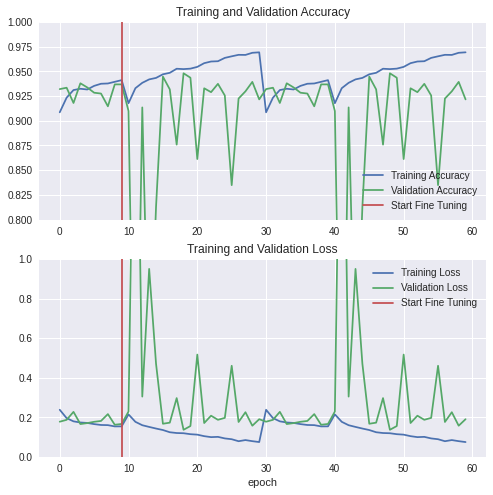

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model Evaluation

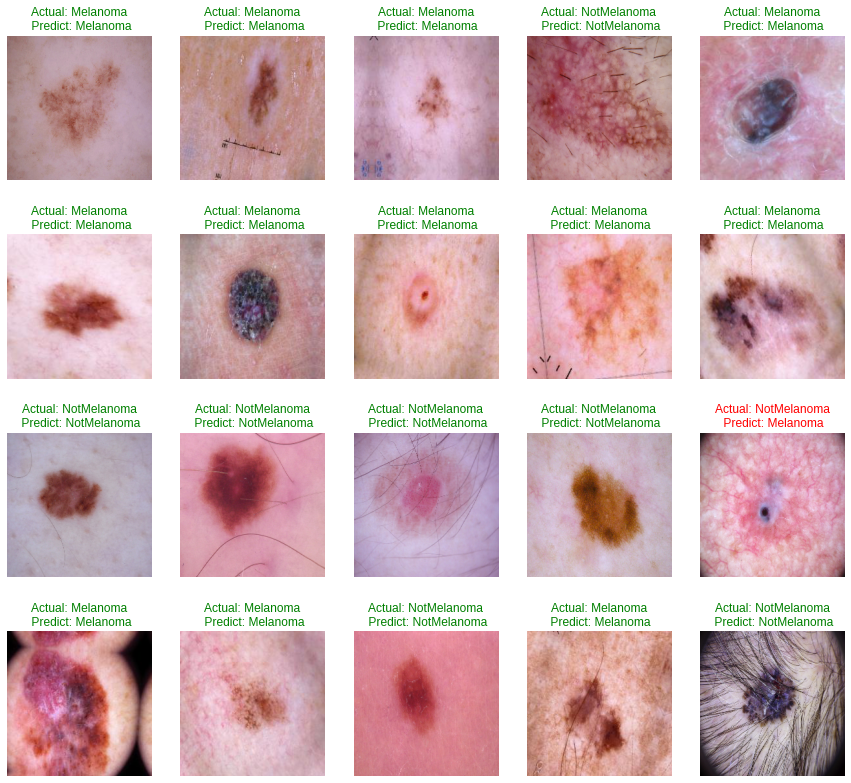

In [0]:
# Obtain one batch of testing images
dataiter = iter(test_generator)
images, labels = dataiter.next()
labels = labels.astype('int')

# Predict the sample images
output = model.predict(images)
# Flatten the numpy array
output = output.squeeze()
# Convert output probabilities to predicted class
preds = tf.where(output > 0.5, 1, 0).numpy()

# Plot the images in the batch, along with predicted and true labels
nrows = 4
ncols = batch_size / nrows
fig = plt.figure(figsize=(15, 14))
for idx in range(20):
    ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title('Actual: {}\n Predict: {}'.format(classes[labels[idx]], classes[preds[idx]]),
                 color=('green' if preds[idx] == labels[idx] else 'red'))

In [0]:
import seaborn as sns

def plot_confusion_matrix(labels, preds):
    conf_matrix = tf.math.confusion_matrix(labels, preds).numpy()

    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax=ax, cmap='Blues');

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(classes);
    ax.yaxis.set_ticklabels(classes);

    print('True Negative (TN):', conf_matrix[0, 0])
    print('False Positive (FP):', conf_matrix[0, 1])
    print('False Negative (FN):', conf_matrix[1, 0])
    print('True Positive (TP):', conf_matrix[1, 1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion matrix (sample images)
True Negative (TN): 7
False Positive (FP): 1
False Negative (FN): 0
True Positive (TP): 12


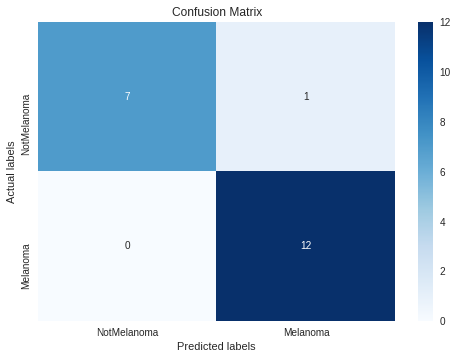

In [0]:
print('Confusion matrix (sample images)')
plot_confusion_matrix(labels, preds)

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(name, labels, output_probabilities, **kwargs):
    fp, tp, _ = roc_curve(labels, output_probabilities)

    fig = plt.figure(figsize=(8,8))
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.legend(loc='lower right')

    print('AUC Score:', roc_auc_score(labels, output_probabilities))

AUC Score: 1.0


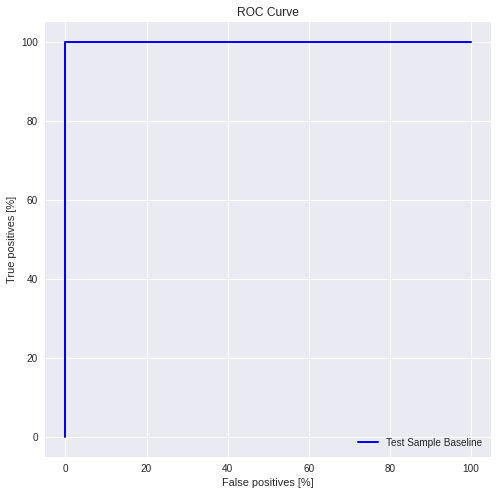

In [0]:
plot_roc('Test Sample Baseline', labels, output, color='b')

In [0]:
labels = test_generator.classes

# Predict the test images
output = model.predict(test_generator)
# Flatten the numpy array
output = output.squeeze()
# Convert output probabilities to predicted class
preds = tf.where(output > 0.5, 1, 0).numpy()

Confusion matrix (full test images)
True Negative (TN): 22
False Positive (FP): 28
False Negative (FN): 24
True Positive (TP): 26


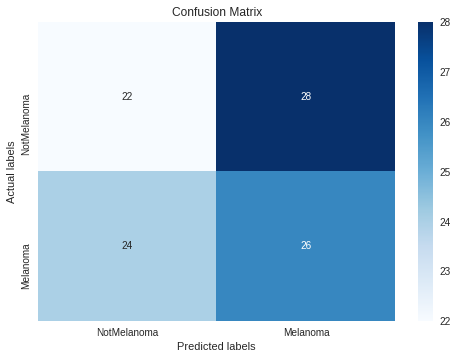

In [0]:
print('Confusion matrix (full test images)')
plot_confusion_matrix(labels, preds)

AUC Score: 0.4674


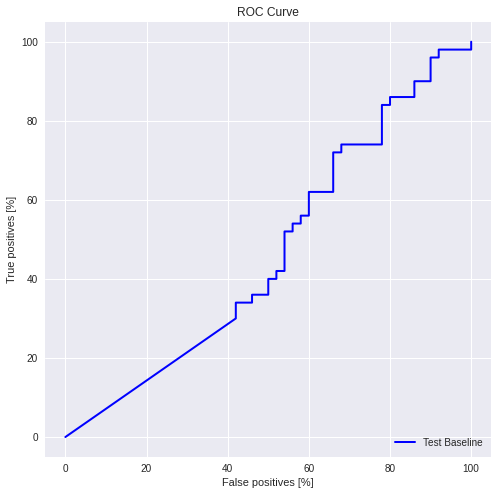

In [0]:
plot_roc('Test Baseline', labels, output, color='b')

## Model Serving

### Add TensorFlow Serving Distribution URI as a Package Source

We will install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) (the default Debian package manager) since Google's Colab runs in a Debian environment. 

Before we can install TensorFlow Serving, we need to add the `tensorflow-model-server` package to the list of packages that Aptitude knows about. Note that we're running as root.

**Note**: This notebook is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving. The Docker Engine is available for a variety of Linux platforms, Windows, and Mac.

In [0]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   8681      0 --:--:-- --:--:-- --:--:--  8707
OK
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:9 https://d

### Install TensorFlow Serving

Now that the Aptitude packages have been updated, we can use the `apt-get` command to install the TensorFlow model server.

In [0]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 64 not upgraded.
Need to get 187 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.2.0 [187 MB]
Fetched 187 MB in 5s (38.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.2.0_all.deb ...
Unpacking tensorflow-model-server (2.2.0) ...
Setting up tensorflow-model-server (2.2.0) ...


### Load the Model

In [0]:
from google.colab import files
files.upload() # upload saved_model.zip

Saving saved_model.zip to saved_model.zip


In [0]:
!unzip -q saved_model.zip -d .

replace ./saved_model/fine_model.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace ./saved_model/base_model.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


In [0]:
import os
from tensorflow.keras.models import load_model

# Load saved model from path
saved_model_dir = './saved_model'
model_path = os.path.join(saved_model_dir, 'model-09-0.95')
model = load_model(model_path)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 2,914,369
Trainable params: 2,880,257
Non-trainable params: 34,112
_________________________________________________________________


### Examine Our Saved Model

We'll use the command line utility `saved_model_cli` to look at the `MetaGraphDefs` and `SignatureDefs` in our SavedModel. The signature definition is defined by the input and output tensors, and stored with the default serving key.

In [0]:
!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['mobilenetv2_1.00_224_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_mobilenetv2_1.00_224_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0609 03:19:04.477906 139950432769920 deprecation.py:506] From /usr/local/lib/python2.7/dist

In [0]:
import tensorflow as tf

MODEL_DIR = '/tmp'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 4944
drwxr-xr-x 2 root root    4096 Jun  9 03:21 assets
-rw-r--r-- 1 root root 5053591 Jun  9 03:21 saved_model.pb
drwxr-xr-x 2 root root    4096 Jun  9 03:21 variables


### Run the TensorFlow Model Server

We will now launch the TensorFlow model server with a bash script. We will use the argument `--bg` to run the script in the background.

Our script will start running TensorFlow Serving and will load our model. Here are the parameters we will use:

* `rest_api_port`: The port that you'll use for requests.


* `model_name`: You'll use this in the URL of your requests.  It can be anything.


* `model_base_path`: This is the path to the directory where you've saved your model.

Also, because the variable that points to the directory containing the model is in Python, we need a way to tell the bash script where to find the model. To do this, we will write the value of the Python variable to an environment variable using the `os.environ` function.

In [0]:
os.environ['MODEL_DIR'] = MODEL_DIR

In [0]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=melanoma_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


Now we can take a look at the server log.

In [0]:
!tail server.log

2020-06-09 03:21:28.493119: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /tmp/1
2020-06-09 03:21:28.723790: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:364] SavedModel load for tags { serve }; Status: success: OK. Took 858529 microseconds.
2020-06-09 03:21:28.751653: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-06-09 03:21:28.751822: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: melanoma_model version: 1}
2020-06-09 03:21:28.753832: I tensorflow_serving/model_servers/server.cc:355] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 223] NET_LOG: Couldn't bind to port 8501
[evhttp_server.cc : 63] NET_LOG: Server has not been terminated. Force termination now.
[evhttp_se

### Prepare the Test Images

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(image_path, target_size=(224,224)):
    # Handle single image and multipe image path
    image_path = tf.constant([image_path]).numpy().astype('str').flatten()

    images = []
    for path in image_path:
        # Load image from image path
        img = load_img(path, target_size=target_size)
        # Convert image to array
        img = img_to_array(img)
        # Rescale image
        # img = img.astype('float') / 255
        # Stack the image array
        images.append(img)

    # Convert batch images to numpy array
    images = tf.stack(images).numpy()
    return images

def predict(model, path, target_size=(224,224)):
    # Load single / multiple image
    images = load_images(path)
    # Predict the probability of image, return array of array
    pred_prob = model.predict(images)
    pred_prob = pred_prob.flatten()
    # Probability of sigmoid function, 0.5 is threshold
    pred_class = tf.where(pred_prob > 0.5, 'Melanoma', 'Not Melanoma').numpy().astype('str')
    return (pred_prob, pred_class)

def show_image(path, title, resize=(224,224)):
    plt.figure()
    img = load_img(path, target_size=resize)
    img = img_to_array(img).astype('int')
    plt.imshow(img)
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

Saving datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024311.jpg to datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024311.jpg
Saving datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024308.jpg to datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024308.jpg
Saving datasets_85479_197225_DermMel_train_sep_Melanoma_AUG_0_1.jpeg to datasets_85479_197225_DermMel_train_sep_Melanoma_AUG_0_1.jpeg
Saving datasets_85479_197225_DermMel_train_sep_Melanoma_AUG_0_0.jpeg to datasets_85479_197225_DermMel_train_sep_Melanoma_AUG_0_0.jpeg
Filename:  datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024311.jpg
Label:  ['Not Melanoma']
Probability: [4.134655e-06]
Filename:  datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024308.jpg
Label:  ['Not Melanoma']
Probability: [3.463266e-06]
Filename:  datasets_85479_197225_DermMel_train_sep_Melanoma_AUG_0_1.jpeg
Label:  ['Not Melanoma']
Probability: [1.2493842e-05]
Filename:  datasets_85479_197225_DermMel_tr

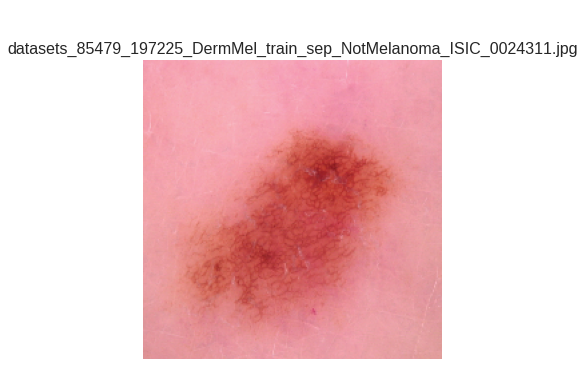

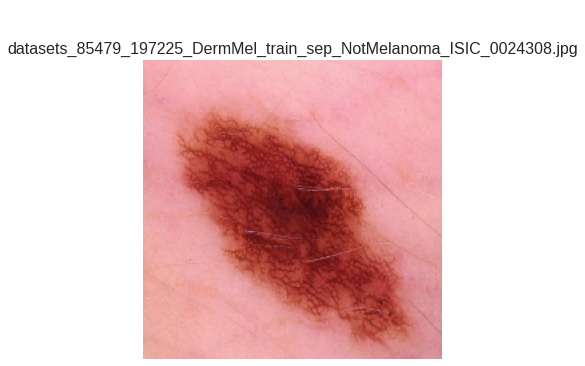

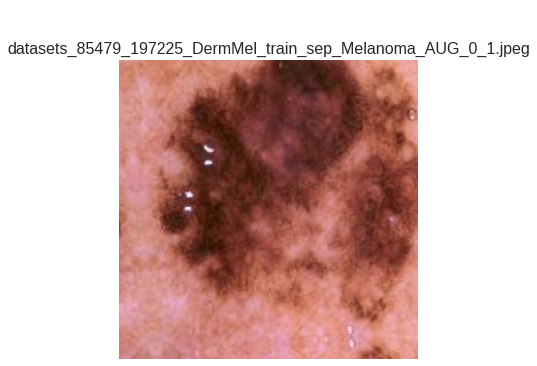

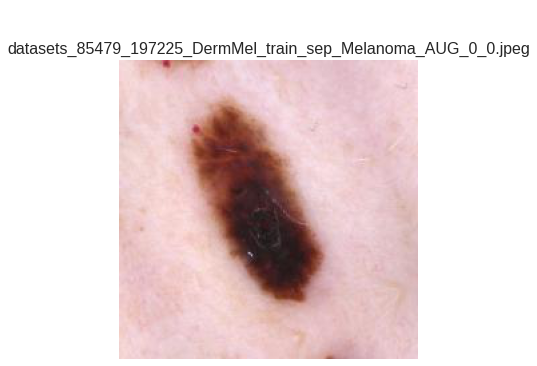

In [0]:
from google.colab import files

# Upload images
uploaded = files.upload()

for path in uploaded.keys():

    # Predict the image
    prob, label = predict(model, path)

    # Show the image
    show_image(path, os.path.basename(path))

    print('Filename: ', path)
    print('Label: ', label)
    print('Probability:', prob)

### Make a request to our model in TensorFlow Serving

In [0]:
import json

images = load_images(list(uploaded.keys()))
images = images.tolist()

data = json.dumps({"signature_name": "serving_default", "instances": images})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 0], [236.0, 204.0, 215.0], [237.0, 205.0, 216.0]]]]}


In [0]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/melanoma_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
print(predictions)

[[4.13465887e-06], [3.46325623e-06], [1.24937478e-05], [1.07604319e-06]]


## Deploy Model on Cloud

### Install Google Cloud Storage Client Libraries

[Reference](https://cloud.google.com/storage/docs/reference/libraries)

In [0]:
!pip install --upgrade google-cloud-storage

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 92kB 4.1MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.16.1 which is incompatible.
ERROR: google-cloud-bigquery 1.21.0 has requirement google-resumable-media!=0.4.0,<0.5.0dev,>=0.3.1, but you'll have google-resumable-media 0.5.1 which is incompatible.
  Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3
  Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1
  Found existing installation: google-auth 1.7.2
    Uninstalling google-auth-1.7.2:
      Successfully uninstalled google-auth-1.7.2
  Found existing installation: google-cloud-storage 1.18.1
    Uninstalling google-cloud-storage-1.18.1:
      Successfully uninstalled google-cloud-s

### Setting up authentication

In [6]:
# First run this command to login to our GCP
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&code_challenge=3SjCKFj40W0qCJ1rMx-2X0-53nOU0Ftbvb5TTlfmPu0&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: 4/0wHqF8mMWGuSvwoNt6DqocyigsHcqHMXDfo1vqXIUdXL8Sei02FvfyI

You are now logged in as [abuwildanm@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [7]:
# Set project using our project ID
!gcloud config set project absolute-broker-279214

Updated property [core/project].


In [0]:
# Create service account
!gcloud iam service-accounts create melanoma-service

Created service account [melanoma-service].


In [8]:
# Create IAM role to our service account
!gcloud projects add-iam-policy-binding absolute-broker-279214 --member "serviceAccount:melanoma-service@absolute-broker-279214.iam.gserviceaccount.com" --role "roles/owner"

Updated IAM policy for project [absolute-broker-279214].
bindings:
- members:
  - serviceAccount:service-376640256474@gcp-sa-automl.iam.gserviceaccount.com
  role: roles/automl.serviceAgent
- members:
  - serviceAccount:service-376640256474@gcf-admin-robot.iam.gserviceaccount.com
  role: roles/cloudfunctions.serviceAgent
- members:
  - serviceAccount:service-376640256474@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:376640256474-compute@developer.gserviceaccount.com
  - serviceAccount:376640256474@cloudservices.gserviceaccount.com
  - serviceAccount:absolute-broker-279214@appspot.gserviceaccount.com
  role: roles/editor
- members:
  - serviceAccount:service-376640256474@cloud-ml.google.com.iam.gserviceaccount.com
  role: roles/ml.serviceAgent
- members:
  - serviceAccount:melanoma-service@absolute-broker-279214.iam.gserviceaccount.com
  - user:abuwildanm@gmail.com
  - user:virgiawan.huda.akbar@gmail.com
  role: roles/owner
- mem

In [9]:
# Generate service account key file
!gcloud iam service-accounts keys create service-account-key.json --iam-account melanoma-service@absolute-broker-279214.iam.gserviceaccount.com

created key [7496fd372bb703661cd0e2dcac744256f27c004b] of type [json] as [service-account-key.json] for [melanoma-service@absolute-broker-279214.iam.gserviceaccount.com]


In [0]:
# Setting the environment variable
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./service-account-key.json"

### Create bucket to store the model

[Reference](https://cloud.google.com/storage/docs/creating-buckets)

In [0]:
from google.cloud import storage

def create_bucket(bucket_name, location):
    """Creates a new bucket."""
    # bucket_name = "your-new-bucket-name"
    # location = "your-bucket-location"

    storage_client = storage.Client()
    bucket = storage_client.create_bucket(bucket_name, location=location)
    print("Bucket {} created".format(bucket.name))

In [0]:
create_bucket('melanoma-bucket', 'asia-southeast1')

/usr/local/lib/python3.6/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.6/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnin

Bucket melanoma-bucket created


In [0]:
# Upload our saved model directory to our bucket
!gsutil -m cp -r ./saved_model gs://melanoma-bucket

Copying file://./saved_model/base_model.h5 [Content-Type=application/octet-stream]...
Copying file://./saved_model/model-04-0.94/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./saved_model/model-09-0.94/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./saved_model/fine_model.h5 [Content-Type=application/octet-stream]...
Copying file://./saved_model/model-04-0.94/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://./saved_model/model-04-0.94/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
Copying file://./saved_model/model-04-0.94/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./saved_model/model-09-0.94/variables/variables.data-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://./saved_model/model-09-0.94/variables/variables.data-00001-of-00002 [Content-Type=application/octet-stream]...
Copying fi

### Create model in AI Platform

In [0]:
# Create model
!gcloud ai-platform models create melanoma_model --enable-logging --regions=asia-northeast1 

Created ml engine model [projects/absolute-broker-279214/models/melanoma_model].


In [0]:
# Create version of model
!gcloud ai-platform versions create v1 --model=melanoma_model --framework=tensorflow --origin=saved_model/model-09-0.95 --runtime-version=2.1 --staging-bucket=gs://melanoma-bucket

### Upload image to Cloud Storage 

In [0]:
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

In [31]:
from google.colab import files

# Upload images
uploaded = files.upload()

Saving amer_sign3.png to amer_sign3 (1).png


In [25]:
import os
upload_blob('melanoma-bucket', list(uploaded.keys())[0], os.path.join('uploaded_files', list(uploaded.keys())[0]))

File datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024311.jpg uploaded to uploaded_files/datasets_85479_197225_DermMel_train_sep_NotMelanoma_ISIC_0024311.jpg.


### Prepare the Test Images

In [0]:
import os
from google.cloud import storage
import tensorflow as tf

def read_image(filename, target_size=(224,224)):
    # Get cloud storage client
    storage_client = storage.Client()
    # Get bucket
    bucket_name = 'melanoma-bucket'
    bucket = storage_client.bucket(bucket_name)

    # Handle single image and multipe image path
    image_filename = tf.constant([filename]).numpy().astype('str').flatten()

    # Get all images
    images = []
    for fname in image_filename:
        # Get blob object
        source_blob_name = os.path.join('uploaded_files', fname)
        blob = bucket.blob(source_blob_name)
        # Get the image from cloud storage
        bytes_image = blob.download_as_string()
        # Convert byte image to image array
        image_array = tf.io.decode_image(bytes_image, channels=3)
        # Resize the image array
        image_array = tf.image.resize(image_array, target_size)
        # Stack the image array
        images.append(image_array)

    # Convert batch images to numpy array
    images = tf.stack(images).numpy()
    return images

In [32]:
images = read_image(list(uploaded.keys()))
print(images.shape)

(1, 224, 224, 3)


### Predict the test image using Cloud Storage Model

In [0]:
import os
import tempfile
from google.cloud import storage
import tensorflow as tf
from tensorflow.keras.models import load_model

def get_model(model_path):
    # Get cloud storage client
    storage_client = storage.Client()
    # Get bucket
    bucket_name = 'melanoma-bucket'
    bucket = storage_client.bucket(bucket_name)
    # Get blob object
    source_blob_name = os.path.join('saved_model', model_path)
    blob = bucket.blob(source_blob_name)
    # Save the model to temporary directory
    temp_model = os.path.join(tempfile.gettempdir(), model_path)
    blob.download_to_filename(temp_model)
    # Load the model
    model = load_model(temp_model)
    return model

def model_predict(model, image_array):
    # Predict the probability of image, return array of array
    pred_prob = model.predict(image_array)
    pred_prob = pred_prob.flatten()
    # Probability of sigmoid function, 0.5 is threshold
    pred_class = tf.where(pred_prob > 0.5, 'Melanoma', 'Not Melanoma').numpy().astype('str')
    return (pred_prob.tolist(), pred_class.tolist())

In [34]:
model = get_model('fine_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 2,914,369
Trainable params: 2,337,729
Non-trainable params: 576,640
_________________________________________________________________


In [35]:
model_predict(model, images)

([8.054310799039677e-13], ['Not Melanoma'])

### Predict the test image using AI Platform Model

In [0]:
import googleapiclient.discovery

def predict_json(project, model, image_array, target_size=(224,224), version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        image_array (array): array of image
        target_size (tuple/list): desired size of image
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>

    images = image_array.astype('int')
    images = images.tolist()

    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': images}
    ).execute()

    predictions = response['predictions'][0]
    result = predictions['dense_2'][0]
    result = round(float(result))

    if 'error' in response:
        raise RuntimeError(response['error'])

    if result == 0:
        return 'Not Melanoma'
    else:
        return 'Melanoma'

In [0]:
predict_json('absolute-broker-279214', 'melanoma_model', images)

'Not Melanoma'

### Deploy model using Cloud Functions

Copy all this code to Cloud Functions inline editor

[Reference](https://cloud.google.com/functions/docs/writing/http#writing_http_files-python)

In [0]:
import os
import tempfile
from werkzeug.utils import secure_filename
from flask import jsonify
from google.cloud import storage
import googleapiclient.discovery
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name))

def read_image(filename, target_size=(224,224)):
    # Get cloud storage client
    storage_client = storage.Client()
    # Get bucket
    bucket_name = 'melanoma-bucket'
    bucket = storage_client.bucket(bucket_name)

    # Handle single image and multipe image path
    image_filename = tf.constant([filename]).numpy().astype('str').flatten()

    # Get all images
    images = []
    for fname in image_filename:
        # Get blob object
        source_blob_name = os.path.join('uploaded_files', fname)
        blob = bucket.blob(source_blob_name)
        # Get the image from cloud storage
        bytes_image = blob.download_as_string()
        # Convert byte image to image array
        image_array = tf.io.decode_image(bytes_image, channels=3)
        # Resize the image array
        image_array = tf.image.resize(image_array, target_size)
        # Stack the image array
        images.append(image_array)

    # Convert batch images to numpy array
    images = tf.stack(images).numpy()
    return images

def get_model(model_path):
    # Get cloud storage client
    storage_client = storage.Client()
    # Get bucket
    bucket_name = 'melanoma-bucket'
    bucket = storage_client.bucket(bucket_name)
    # Get blob object
    source_blob_name = os.path.join('saved_model', model_path)
    blob = bucket.blob(source_blob_name)
    # Save the model to temporary directory
    temp_model = os.path.join(tempfile.gettempdir(), model_path)
    blob.download_to_filename(temp_model)
    # Load the model
    model = load_model(temp_model)
    return model

def model_predict(model, image_array):
    # Predict the probability of image, return array of array
    pred_prob = model.predict(image_array)
    pred_prob = pred_prob.flatten()
    # Probability of sigmoid function, 0.5 is threshold
    pred_class = tf.where(pred_prob > 0.5, 'Melanoma', 'Not Melanoma').numpy().astype('str')
    return (pred_prob.tolist(), pred_class.tolist())

def predict_json(project, model, image_array, target_size=(224,224), version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        image_array (array): array of image
        target_size (tuple/list): desired size of image
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>

    images = image_array.astype('int')
    images = images.tolist()

    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': images}
    ).execute()

    predictions = response['predictions'][0]
    result = predictions['dense_2'][0]
    result = round(float(result))

    if 'error' in response:
        raise RuntimeError(response['error'])

    if result == 0:
        return 'Not Melanoma'
    else:
        return 'Melanoma'

def delete_blob(bucket_name, blob_name):
    """Deletes a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # blob_name = "your-object-name"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.delete()

    print("Blob {} deleted.".format(blob_name))

# Helper function that computes the filepath to save files to
def get_file_path(filename):
    # Note: tempfile.gettempdir() points to an in-memory file system
    # on GCF. Thus, any files in it must fit in the instance's memory.
    file_name = secure_filename(filename)
    return os.path.join(tempfile.gettempdir(), file_name)

def parse_multipart(request):
    """ Parses a 'multipart/form-data' upload request
    Args:
        request (flask.Request): The request object.
    Returns:
        The response text, or any set of values that can be turned into a
         Response object using `make_response`
        <http://flask.pocoo.org/docs/1.0/api/#flask.Flask.make_response>.
    """

    if request.method == 'POST':
        bucket_name = 'melanoma-bucket'
        destination_blob_dir = 'uploaded_files'

        # This code will process each non-file field in the form
        fields = {}
        data = request.form.to_dict()
        for field in data:
            fields[field] = data[field]
            print('Processed field: %s' % field)

        # This code will process each file uploaded
        files = request.files.to_dict()
        image_filename = []
        for file_name, file in files.items():
            # Note: GCF may not keep files saved locally between invocations.
            # If you want to preserve the uploaded files, you should save them
            # to another location (such as a Cloud Storage bucket).
            
            # Save file to temporary directory 
            file.save(get_file_path(file_name))

            # Upload file to cloud storage
            source_file_path = get_file_path(file_name)
            destination_blob_name = os.path.join(destination_blob_dir, file_name)
            upload_blob(bucket_name, source_file_path, destination_blob_name)

            image_filename.append(file_name)
            print('Processed file: %s' % file_name)

        # Clear temporary directory
        for file_name in files:
            file_path = get_file_path(file_name)
            os.remove(file_path)

        # # Get image from cloud storage
        image_array = read_image(image_filename)

        # Get the model from cloud storage
        model = get_model('fine_model.h5')
        # Predict image using model from cloud storage
        pred_prob, pred_class = model_predict(model, image_array)

        # # Predict image using AI Platform model (optional)
        # Only can handle one image per request, if more than that then the payload limit is exceeded
        # project_id = 'absolute-broker-279214'
        # model_name = 'melanoma_model'
        # predict = predict_json(project_id, model_name, image_array)

        # This code will delete each file uploaded
        files = request.files.to_dict()
        for file_name in files:
            # Delete file from cloud storage
            destination_blob_name = os.path.join(destination_blob_dir, file_name)
            delete_blob(bucket_name, destination_blob_name)
            
            print('Deleted file: %s' % file_name)

        return jsonify({'predicted_probability':pred_prob, 'predicted_class':pred_class})
    else:
        return 'Please send POST request'

### Consume Cloud Functions

[Reference: How to send a “multipart/form-data” with requests in python?](https://stackoverflow.com/questions/43042805/how-to-send-a-multipart-form-data-with-requests-in-python)

[Reference: Python Requests post() Method](https://www.w3schools.com/python/ref_requests_post.asp)

[Reference: Create Simple HTML Form for Upload an Image](https://www.w3schools.com/php/php_file_upload.asp)

In [0]:
import json
import requests

SERVER_URL = 'https://asia-northeast1-absolute-broker-279214.cloudfunctions.net/melanoma-function'
image_file = open(list(uploaded.keys())[0], 'rb')
# image_file = [open(image, 'rb') for image in list(uploaded.keys)]
files = {"image.jpg" : image_file}
payload = {"judul": "ini judul", "pesan": 123}

response = requests.post(SERVER_URL, data=payload, files=files)
print(response.content)
print(response.text)
print(response.status_code)

b'{"predicted_class":["Not Melanoma"],"predicted_probability":[6.17938122546291e-12]}\n'
{"predicted_class":["Not Melanoma"],"predicted_probability":[6.17938122546291e-12]}

200
